In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np
import dill                        
# filename = 'Prediction.Methylation.ipynb.pkl'
# dill.dump_session(filename)
# dill.load_session(filename)

In [2]:
from combat.pycombat import pycombat
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, KFold, cross_validate, train_test_split, LeaveOneOut
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier, ElasticNetCV, Lasso
from sklearn.metrics import accuracy_score, auc, roc_curve, auc, precision_recall_curve, average_precision_score , classification_report, confusion_matrix,ConfusionMatrixDisplay,f1_score, precision_score, recall_score, matthews_corrcoef, fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier , HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import Lasso
from numpy import interp
from sklearn import svm 
import matplotlib.pyplot as plt
scaler = StandardScaler()

#### Senescence based transcriptome

In [3]:
# GSE98440
df = pd.read_csv('../Validation/Transcriptome/Senescence/GSE98440_norm_counts_IMR90pro_sen.csv.gz', sep='\t', low_memory=False)
GeneSymbols = pd.read_csv('../Validation/Human.GRCh38.p13.annot (2).tsv.gz', compression='gzip', comment='#', sep='\t')
df.index = df['Unnamed: 0'].map(GeneSymbols.dropna(subset='EnsemblGeneID').set_index('EnsemblGeneID')['Symbol'].to_dict())
df = df.drop('Unnamed: 0', axis=1).iloc[:-1,:]
df = df[~ df.index.isna()]
# df.T.to_pickle('../ImmunotherapyAnalysis/Transcriptome/GSE98440.Senescence.pkl')

/tmp/ipykernel_2142074/792307721.py:3: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  GeneSymbols = pd.read_csv('../Validation/Human.GRCh38.p13.annot (2).tsv.gz', compression='gzip', comment='#', sep='\t')


In [6]:
df = pd.read_csv('../Validation/Transcriptome/GSE98440_norm_counts_HUVECpro_sen.csv.gz', sep='\t', low_memory=False)
GeneSymbols = pd.read_csv('../Validation/Human.GRCh38.p13.annot (2).tsv.gz', compression='gzip', comment='#', sep='\t')
df.index = df['Unnamed: 0'].map(GeneSymbols.dropna(subset='EnsemblGeneID').set_index('EnsemblGeneID')['Symbol'].to_dict())
df = df.drop('Unnamed: 0', axis=1).iloc[:-1,:]
df = df[~ df.index.isna()]

/tmp/ipykernel_2142074/3360887356.py:2: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  GeneSymbols = pd.read_csv('../Validation/Human.GRCh38.p13.annot (2).tsv.gz', compression='gzip', comment='#', sep='\t')


In [5]:
df = pd.read_csv('../Validation/Transcriptome/GSE98440_norm_counts_MSCpro_sen.csv.gz', sep='\t', low_memory=False)
GeneSymbols = pd.read_csv('../Validation/Human.GRCh38.p13.annot (2).tsv.gz', compression='gzip', comment='#', sep='\t')
df.index = df['Unnamed: 0'].map(GeneSymbols.dropna(subset='EnsemblGeneID').set_index('EnsemblGeneID')['Symbol'].to_dict())
df = df.drop('Unnamed: 0', axis=1).iloc[:-1,:]
df = df[~ df.index.isna()]
# df.T.to_pickle('../Validation/Transcriptome/MSC.Senescence.pkl')


/tmp/ipykernel_2142074/3595842199.py:2: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  GeneSymbols = pd.read_csv('../Validation/Human.GRCh38.p13.annot (2).tsv.gz', compression='gzip', comment='#', sep='\t')


In [7]:
# GSE63577
df = pd.read_csv('../Validation/Transcriptome/Senescence//GSE63577_norm_counts_TPM_GRCh38.p13_NCBI.tsv.gz', sep='\t')
df['GeneID'] = df['GeneID'].map(GeneSymbols.set_index('GeneID')['Symbol']).values
df.set_index('GeneID', inplace=True)
df = df.T

In [8]:
dfMeta = pd.read_table('../Validation/Transcriptome/Senescence//GSE63577_series_matrix.txt', sep='	').T
dfMeta.columns = dfMeta.iloc[:1,:].values[0]
dfSen = df.index.map(dfMeta.set_index(' Sample_geo_accession')[' Sample_characteristics_ch1'].iloc[1:,:1].to_dict()[' Sample_characteristics_ch1'])
df['Senescence'] = dfSen.str.replace('population doublings: ','').astype(int).map(lambda x: 0 if x <= 35 else (1 if x > 52 else np.nan))
df = df.dropna()

In [7]:
# df.drop('Senescence', axis=1).to_pickle('../ImmunotherapyAnalysis/Transcriptome/GSE63577.Senescence.pkl')
# df[['Senescence']].to_csv('../ImmunotherapyAnalysis/Transcriptome/GSE63577.Labels.csv')

### Senescence biomarkers

#### Predicted methylation from transcriptome 

In [3]:
import glob
AllCpgs = glob.glob("Predicted.Methylation/HUVEC/*.csv")

GSE98440_HUVEC = pd.DataFrame()
for csv in AllCpgs:
    try:
        newCSV = pd.read_csv(csv, low_memory=False)
        # newCSV = newCSV.drop('Unnamed: 0', axis=1)
        GSE98440_HUVEC = pd.concat([GSE98440_HUVEC, newCSV],axis=1)
    except:pass
GSE98440_HUVEC = GSE98440_HUVEC.loc[:,~GSE98440_HUVEC.columns.duplicated()].copy()
GSE98440_HUVEC = GSE98440_HUVEC.set_index('Unnamed: 0')
GSE98440_HUVEC = np.clip(GSE98440_HUVEC, 0,1)
GSE98440_HUVEC['Labels'] = GSE98440_HUVEC.index.map(lambda x: 1 if 'sen' in x else 0).values
GSE98440_HUVEC.shape

(6, 18758)

In [4]:
import glob
AllCpgs = glob.glob("Predicted.Methylation/MSC/*.csv")

GSE98440_MSC = pd.DataFrame()
for csv in AllCpgs:
    try:
        newCSV = pd.read_csv(csv, low_memory=False)
        # newCSV = newCSV.drop('Unnamed: 0', axis=1)
        GSE98440_MSC = pd.concat([GSE98440_MSC, newCSV],axis=1)
    except:pass
GSE98440_MSC = GSE98440_MSC.loc[:,~GSE98440_MSC.columns.duplicated()].copy()
GSE98440_MSC = GSE98440_MSC.set_index('Unnamed: 0')
GSE98440_MSC = np.clip(GSE98440_MSC, 0,1)
GSE98440_MSC['Labels'] = GSE98440_MSC.index.map(lambda x: 1 if 'sen' in x else 0).values
GSE98440_MSC.shape

(8, 22785)

In [5]:
import glob
AllCpgs = glob.glob("Predicted.Methylation/GSE98440/*.csv")

GSE98440PredMeth = pd.DataFrame()
for csv in AllCpgs:
    try:
        newCSV = pd.read_csv(csv, low_memory=False)
        # newCSV = newCSV.drop('Unnamed: 0', axis=1)
        GSE98440PredMeth = pd.concat([GSE98440PredMeth, newCSV],axis=1)
    except:pass
GSE98440PredMeth = GSE98440PredMeth.loc[:,~GSE98440PredMeth.columns.duplicated()].copy()
GSE98440PredMeth = GSE98440PredMeth.set_index('Unnamed: 0')
GSE98440PredMeth = np.clip(GSE98440PredMeth, 0,1)
GSE98440PredMeth['Labels'] = GSE98440PredMeth.index.map(lambda x: 1 if 'sen' in x else 0).values
GSE98440PredMeth.shape

(8, 20329)

In [6]:
import glob
AllCpgs = glob.glob("Predicted.Methylation/GSE63577/*.csv")

GSE63577PredMeth = pd.DataFrame()
for csv in AllCpgs:
    try:
        newCSV = pd.read_csv(csv, low_memory=False)
        # newCSV = newCSV.drop('Unnamed: 0', axis=1)
        GSE63577PredMeth = pd.concat([GSE63577PredMeth, newCSV],axis=1)
    except:pass
GSE63577PredMeth = GSE63577PredMeth.loc[:,~GSE63577PredMeth.columns.duplicated()].copy()
GSE63577PredMeth = GSE63577PredMeth.set_index('Unnamed: 0')
GSE63577PredMeth = np.clip(GSE63577PredMeth, 0,1)
GSE63577PredMeth.loc[:, 'Labels'] = pd.read_csv('Transcriptome/GSE63577.Labels.csv')['Senescence'].astype(int).values
GSE63577PredMeth.shape

(36, 26538)

#### Validation cohorts

In [7]:
## Methylation Datasets 
GSE91069SenVal = pd.read_pickle('ValidationCohorts/Senescence/GSE91069.matrix.pkl')
GSE91069SenVal.loc[:,'Labels'] = pd.read_csv('ValidationCohorts/Senescence/GSE91069.labels.csv')['Label'].values
GSE227160SenVal = pd.read_pickle('ValidationCohorts/Senescence/GSE227160.matrix.pkl')
GSE227160SenVal.loc[:,'Labels'] = pd.read_csv('ValidationCohorts/Senescence/GSE227160.labels.csv')['Label'].values
GSE131280SenVal = pd.read_pickle('ValidationCohorts/Senescence/GSE131280.matrix.pkl')
GSE131280SenVal.loc[:,'Labels'] = pd.read_csv('ValidationCohorts/Senescence/GSE131280.labels.csv')['B Label'].values

In [8]:
commomCPGs = GSE98440PredMeth.drop('Labels', axis=1).columns.intersection(GSE98440_HUVEC.columns).intersection(
    GSE98440_MSC.columns).intersection(GSE63577PredMeth.columns).intersection(GSE91069SenVal.columns).intersection(GSE227160SenVal.columns).intersection(GSE131280SenVal.columns)

In [9]:
MergedSenescence = pd.concat([pd.DataFrame(scaler.fit_transform(i), columns=commomCPGs) for i in [GSE91069SenVal[commomCPGs], GSE131280SenVal[commomCPGs],GSE227160SenVal[commomCPGs]]])
MergedSenescence['Labels'] = pd.concat([GSE91069SenVal.iloc[:,-1:], GSE131280SenVal.iloc[:,-1:],GSE227160SenVal.iloc[:,-1:]])['Labels'].values
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name
MergedSenescence['DataSet'] = pd.concat([pd.Series(len(i) * [get_df_name(i).replace('SenVal','')]) for i in [GSE91069SenVal, GSE131280SenVal,GSE227160SenVal]]).values

#### Training Model

In [10]:
X = scaler.fit_transform(GSE63577PredMeth[commomCPGs])
y = GSE63577PredMeth['Labels'].values
model = LogisticRegression(random_state=42, n_jobs=-1,penalty='l1', solver='saga', tol=1000)
model.fit(X,y)
# np.mean(cross_val_score(model, X, y, scoring='accuracy',cv=5,))

LogisticRegression(n_jobs=-1, penalty='l1', random_state=42, solver='saga',
                   tol=1000)

In [11]:
SenescentCPGs = pd.DataFrame(model.coef_[0], index=commomCPGs)
SenescentCPGs = SenescentCPGs[SenescentCPGs[0] != 0]
SenescentCPGs = SenescentCPGs.loc[SenescentCPGs[0].abs().sort_values(ascending=False).index].index[:500]

In [12]:
X = scaler.fit_transform(GSE63577PredMeth[SenescentCPGs])
y = GSE63577PredMeth['Labels'].values
model = LogisticRegression(random_state=42, n_jobs=-1,penalty='l1', solver='saga', tol=1000)
model.fit(X,y)
# np.mean(cross_val_score(model, X, y, scoring='f1_micro',cv=5,))

LogisticRegression(n_jobs=-1, penalty='l1', random_state=42, solver='saga',
                   tol=1000)

In [14]:
datasets ={'GSE98440 - Fibro (Validation)':GSE98440PredMeth,'GSE98440 - HUVEC (Validation)':GSE98440_HUVEC,'GSE98440 - MSC (Validation)':GSE98440_MSC,'GSE91069 - DNAm (Validation)':GSE91069SenVal, 'GSE22716 - DNAm (Validation)':GSE227160SenVal, 'GSE13128 - DNAm (Validation)':GSE131280SenVal, '   Merged   - DNAm (Validation)':MergedSenescence}
# pd.concat([GSE98440PredMeth, GSE98440_HUVEC, GSE98440_MSC]).dropna(axis=1)

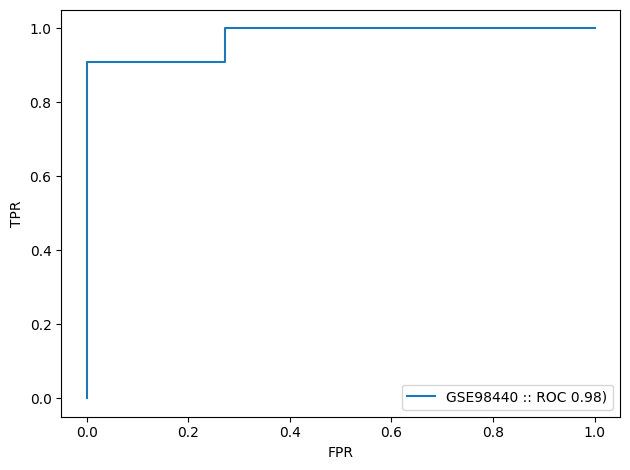

In [20]:
for Datakeys in ['GSE98440 - Fibro (Validation)','GSE98440 - HUVEC (Validation)','GSE98440 - MSC (Validation)']:
    dataset = datasets[Datakeys]
    orig_labels = dataset['Labels'].values
    predicted_labels = model.predict_proba(scaler.fit_transform(dataset[SenescentCPGs].fillna(0)))[:,1]
    fpr, tpr, thresholds = roc_curve(orig_labels,predicted_labels)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{Datakeys} :: ROC {round(roc_auc,2)})')
    plt.legend(loc="lower right")
    plt.xlabel('FPR')
    plt.ylabel('TPR')
plt.tight_layout()

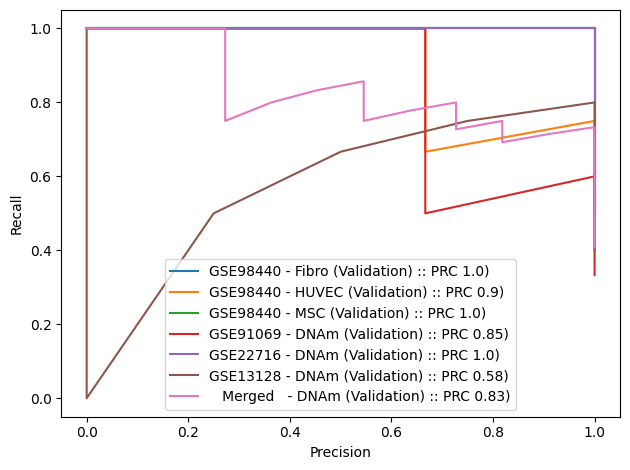

In [32]:
for Datakeys in datasets.keys():
    dataset = datasets[Datakeys]
    orig_labels = dataset['Labels'].values
    predicted_labels = model.predict_proba(scaler.fit_transform(dataset[SenescentCPGs].fillna(0)))[:,1]
    precision, recall, thresholds = precision_recall_curve(orig_labels,predicted_labels)
    roc_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{Datakeys} :: PRC {round(roc_auc,2)})')
    plt.legend(loc="lower right")
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend()
plt.tight_layout()

/home/ansar/projects/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1920x1440 with 0 Axes>

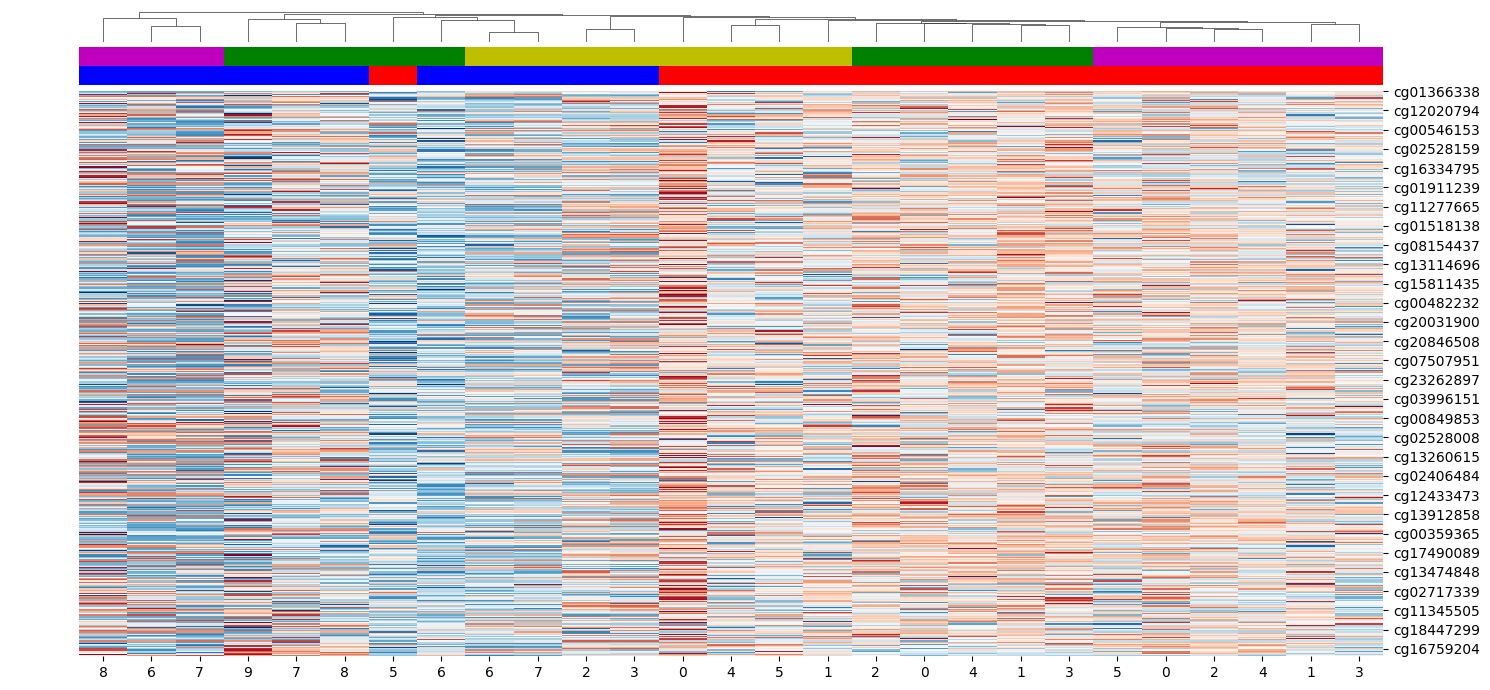

In [153]:
lut = dict(zip(MergedSenescence["DataSet"].unique(), "mgy"))
DataSetColors = MergedSenescence["DataSet"].map(lut)
from matplotlib.patches import Patch
plt.figure(dpi=300)
cm = sns.clustermap(MergedSenescence[SenescentCPGs].T,col_colors=[DataSetColors,
                                                           MergedSenescence["Labels"].map({0:'red',1:'blue'}).values], 
figsize=(15,7),row_cluster=False, dendrogram_ratio=0.05, cmap='RdBu', cbar_kws=None, metric='euclidean')
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='DataSets', bbox_to_anchor=(1.1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')
cm.cax.set_visible(False)
# plt.tight_layout()

### AGE prediction using BRain from GTEX 

In [21]:
### Predicted methylation from brain

In [ ]:
import glob
AllCpgs = glob.glob("Predicted.Methylation/Brain.GTEX/*.csv")

GtexBrain = pd.DataFrame()
for csv in AllCpgs:
    try:
        newCSV = pd.read_csv(csv, low_memory=False)
        # newCSV = newCSV.drop('Unnamed: 0', axis=1)
        GtexBrain = pd.concat([GtexBrain, newCSV],axis=1)
    except:pass
GtexBrain = GtexBrain.loc[:,~GtexBrain.columns.duplicated()].copy()
GtexBrain = GtexBrain.set_index('Unnamed: 0')
# GtexBrain = np.clip(GtexBrain, 0,1)
GtexBrain.loc[:,"Age"] = pd.read_pickle('../GtexBasedPrediction/GTEX.Brain.Meta.pkl')['AGE'].values

In [ ]:
X = scaler.fit_transform(GtexBrain.drop('Age', axis=1).fillna(0))
y = GtexBrain['Age'].values
Train_X ,Test_X,Train_y, Test_y = train_test_split(X, y, test_size=0.4, random_state=42)

In [ ]:
from sklearn.linear_model import Lasso
# COmparison = []
from sklearn.metrics import accuracy_score, auc, roc_curve, root_mean_squared_error,auc, precision_recall_curve, mean_squared_error, average_precision_score , classification_report, confusion_matrix,ConfusionMatrixDisplay,f1_score, precision_score, recall_score, matthews_corrcoef, fbeta_score,mean_absolute_error, median_absolute_error, r2_score
for i in [0.1]:#,0.01, 0.0001, 0.00001]:
    model = ElasticNetCV(n_jobs=-1, random_state=42)
    model.fit(Train_X, Train_y)
    predicted_test = model.predict(Test_X)
    COmparison.append({'lambda':'Brain Scaled', 'RMSE':root_mean_squared_error(predicted_test, Test_y),
                       "MAE":mean_absolute_error(predicted_test, Test_y),
                       "MedAE":median_absolute_error(predicted_test, Test_y),
                       'R2':r2_score(predicted_test, Test_y),
                       "Pearson":pearsonr(predicted_test, Test_y)})
    print(i)
pd.DataFrame(COmparison)

0.1


,lambda,RMSE,MAE,MedAE,R2,Pearson
0,0.1,11.730633,9.371437,7.873431,-1.008593,"(0.5188381272331575, 7.78454920157053e-21)"
1,0.5,12.024293,9.533288,7.445933,-7.315302,"(0.49759403100325433, 4.779493784270209e-19)"
2,1,12.657878,10.177671,8.825098,-25.724770,"(0.431107068702687, 3.4297058745095283e-14)"
3,0.001,12.833706,9.842947,7.680341,-0.247926,"(0.4908124019815049, 1.6766656027958766e-18)"
4,0.1,10.400673,8.142732,6.347918,-1.018571,"(0.6541554181757459, 8.021903572783234e-36)"
5,0.1,12.027564,9.370604,7.024520,-1.727188,"(0.4781500251915284, 1.6230966390072992e-17)"
6,Brain Scaled,10.503349,8.264383,6.596329,-1.284960,"(0.6482501866913086, 5.249432470772017e-35)"


In [ ]:
GtexBrainTpm = pd.read_pickle('../GtexBasedPrediction/GTEX.Brain.TPM.pkl').T
GtexBrainTpm.loc[:,"Age"] = pd.read_pickle('../GtexBasedPrediction/GTEX.Brain.Meta.pkl')['AGE'].values
X = scaler.fit_transform(GtexBrainTpm.drop('Age', axis=1).fillna(0))
y = GtexBrainTpm['Age'].values
Train_X ,Test_X,Train_y, Test_y = train_test_split(X, y, test_size=0.4, random_state=32)

In [ ]:
model = ElasticNetCV(n_jobs=-1, random_state=42)
cross_val_score(model, X, y, scoring='f1_micro',cv=5,)

In [ ]:
from sklearn.metrics import accuracy_score, auc, roc_curve, root_mean_squared_error,auc, precision_recall_curve, mean_squared_error, average_precision_score , classification_report, confusion_matrix,ConfusionMatrixDisplay,f1_score, precision_score, recall_score, matthews_corrcoef, fbeta_score,mean_absolute_error, median_absolute_error, r2_score
for i in [0.1]:#,0.01, 0.0001, 0.00001]:
    model = ElasticNetCV(n_jobs=-1, random_state=42)
    model.fit(Train_X, Train_y)
    predicted_test = model.predict(Test_X)
    COmparison.append({'lambda':'Brain TPM', 'RMSE':root_mean_squared_error(predicted_test, Test_y),
                       "MAE":mean_absolute_error(predicted_test, Test_y),
                       "MedAE":median_absolute_error(predicted_test, Test_y),
                       'R2':r2_score(predicted_test, Test_y),
                       "Pearson":pearsonr(predicted_test, Test_y)})
    print(i)
pd.DataFrame(COmparison)

0.1


,lambda,RMSE,MAE,MedAE,R2,Pearson
0,0.1,11.730633,9.371437,7.873431,-1.008593,"(0.5188381272331575, 7.78454920157053e-21)"
1,0.5,12.024293,9.533288,7.445933,-7.315302,"(0.49759403100325433, 4.779493784270209e-19)"
2,1,12.657878,10.177671,8.825098,-25.724770,"(0.431107068702687, 3.4297058745095283e-14)"
3,0.001,12.833706,9.842947,7.680341,-0.247926,"(0.4908124019815049, 1.6766656027958766e-18)"
4,0.1,10.400673,8.142732,6.347918,-1.018571,"(0.6541554181757459, 8.021903572783234e-36)"
5,0.1,12.027564,9.370604,7.024520,-1.727188,"(0.4781500251915284, 1.6230966390072992e-17)"
6,Brain Scaled,10.503349,8.264383,6.596329,-1.284960,"(0.6482501866913086, 5.249432470772017e-35)"
7,Brain TPM,12.954619,10.120555,8.074882,-4.063929,"(0.4098513660319657, 7.531623196102082e-13)"


In [ ]:
model = ElasticNetCV(n_jobs=-1, random_state=42)
X = scaler.fit_transform(GtexBrainTpm.drop('Age', axis=1).fillna(0))
y = GtexBrainTpm['Age'].values

from sklearn.metrics import make_scorer
scoring = {
    'RMSE': make_scorer(root_mean_squared_error),
    'R2': make_scorer(r2_score),
    'Median': make_scorer(median_absolute_error),
    'MAE': make_scorer(mean_absolute_error)
}
scores = cross_validate(model, X, y, cv=5, scoring=scoring)
RNAscores = scores

In [ ]:
model = ElasticNetCV(n_jobs=-1, random_state=42)
X = scaler.fit_transform(GtexBrain.drop('Age', axis=1).fillna(0))
y = GtexBrain['Age'].values

from sklearn.metrics import make_scorer
scoring = {
    'RMSE': make_scorer(root_mean_squared_error),
    'R2': make_scorer(r2_score),
    'Median': make_scorer(median_absolute_error),
    'MAE': make_scorer(mean_absolute_error)
}
scores = cross_validate(model, X, y, cv=5, scoring=scoring)
Methscores = scores

<Figure size 1920x1440 with 0 Axes>

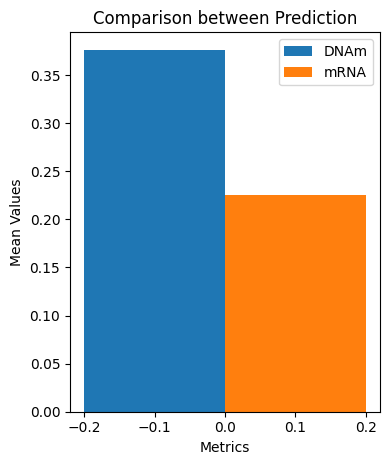

In [ ]:
metrics = ['test_RMSE', 'test_Median', 'test_MAE']
x = np.arange(len(metrics))  # Label locations
plt.figure(dpi=300)
# Plot Comparison
fig, ax = plt.subplots(figsize=(4, 4.75))

bar_width = 0.35
bars1 = ax.bar(x - bar_width/2, [np.mean(Methscores[m]) for m in metrics], bar_width, label='DNAm')
bars2 = ax.bar(x + bar_width/2, [np.mean(RNAscores[m]) for m in metrics], bar_width, label='mRNA')

# Add labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Values')
ax.set_title('Comparison between Prediction')
# ax.set_xticks(x)
# ax.set_xticklabels(metrics, rotation=45)
ax.legend()

# Display plot
plt.tight_layout()
# plt.show()